# Sprawling indices: Overview
* An overview of the different steps associated to the calculation of the sprawling indices

In [1]:
%load_ext autoreload
%autoreload 2

# For graphs
%matplotlib inline

# snippet for relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import osmnx as ox
import matplotlib.pyplot as plt
from src.core import get_processed_osm_data, get_route_graph, get_indices_grid
from src.osm.osm_tags import activity_classification
from src.sprawl.utils import divide_long_edges_graph
from src.sprawl.landusemix import compute_grid_landusemix
from src.sprawl.accessibility import compute_grid_accessibility
from src.sprawl.dispersion import compute_grid_dispersion

ox.config(log_file=True, log_console=True, log_name='sprawl_overview', log_filename='sprawl_overview', use_cache=True)
figsize = (8,6)

# Process OpenStreetMap data
* Advantages:
    * World-wide coverage
    * Homogeneity of data
    * Open data
    * Geo-localized data
    * Crowd-sourced data: rapid updates
    * Contains street network infrastructure, buildings and land use information
* Disadvantages:
    * Missing data

### Get bounds for an input city

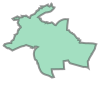

In [2]:
city_ref = "Lyon"

# Get shape for city
city_poly = ox.gdf_from_place(city_ref, which_result=1)
west, south, east, north = city_poly.geometry[0].bounds
# Polygon
city_poly.geometry[0]

## Process OSM data for region of interest
* Buildings and points associated with an activity or residential land use are retrieved

In [3]:
# Retrieve OSM data
region_args = {"north":north, "south":south, "west":west, "east":east}
df_osm_built, df_osm_building_parts, df_osm_pois = get_processed_osm_data(city_ref, region_args)

### Output
* df_osm_built: Buildings
* df_osm_buiding_parts: Building parts
* df_osm_pois: Points of Interest (POIs)

### Coordinate reference system
* The geometries are projected to UTM coordinates using the most appropriate zone
* crs: Attribute that denotes the coordinate reference system of the geometries

### Characteristics
* geometry: Geometries associated to buildings/points of interest
* osm_id: OpenStreetMap identification
* height_tags: OSM tags corresponding to a building's height: http://wiki.openstreetmap.org/wiki/Key:building:levels
* classification: Land use classification: 'activity', 'residential', or 'mixed' 
* key_value: OpenStreetMap tags which define their land use: http://wiki.openstreetmap.org/wiki/Map_Features
* activity_type: For activity land uses, define their type of activity; 'commercial/industrial', 'leisure/amenity', or 'shop'
* containing_parts: Indices corresponding to the containing building parts
* containing_poi: Indices corresponding to the containing Points of Interest
* activity_category: Specific activity categories corresponding to input land use
* building_levels: Effective number of building levels
* landuses_m2: Building's area associated to each land use

In [4]:
df_osm_built.crs

{'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'units': 'm', 'zone': 31}

In [5]:
df_osm_built.head()

,osm_id,height_tags,classification,key_value,containing_parts,containing_poi,activity_category,building_levels,landuses_m2,geometry
0,4132070,{},residential,{'inferred': None},NaN,NaN,NaN,1.0,"{'activity': 0, 'residential': 23812.857363351...","POLYGON ((642998.1607107769 5063921.492375897,..."
1,4132822,{},residential,{'inferred': None},NaN,NaN,NaN,1.0,"{'activity': 0, 'residential': 24726.790661195...","POLYGON ((642304.2623520138 5063963.354271129,..."
2,4132823,{},activity,{'inferred': 'industrial'},NaN,NaN,[commercial/industrial],1.0,"{'activity': 15739.339584039455, 'residential'...","POLYGON ((642947.6784441767 5064344.414166581,..."
3,4132858,{},residential,{'inferred': None},NaN,NaN,NaN,1.0,"{'activity': 0, 'residential': 21243.734768721...","POLYGON ((642660.3485008399 5063707.845752512,..."
4,4132946,{},activity,{'inferred': 'industrial'},NaN,NaN,[commercial/industrial],1.0,"{'activity': 4549.197690431602, 'residential':...","POLYGON ((642864.6654569099 5064485.970018252,..."


In [6]:
df_osm_building_parts.head()

,osm_id,height_tags,classification,key_value,activity_category,building_levels,geometry
0,48119437,{'building:levels': 5.0},NaN,{},NaN,5.0,"POLYGON ((642898.4886805566 5067894.365974966,..."
1,82260111,{'building:levels': 8.0},NaN,{},NaN,8.0,"POLYGON ((642658.1301444267 5068420.599682585,..."
2,85000364,"{'building:min_level': 1.0, 'building:levels':...",residential,{'building:part': 'residential'},NaN,15.0,"POLYGON ((644727.7089179948 5070831.028569627,..."
3,85040012,{'building:levels': 3.0},NaN,{},NaN,3.0,"POLYGON ((646170.8095930892 5072026.835103966,..."
4,85068281,{'building:levels': 3.0},NaN,{},NaN,3.0,"POLYGON ((646453.9102252155 5072076.179136776,..."


In [7]:
df_osm_pois.head()

,osm_id,classification,key_value,activity_category,geometry
0,25178719,activity,{'amenity': 'fuel'},[leisure/amenity],POINT (654665.8982644979 5063410.682837798)
1,25179233,activity,{'amenity': 'fuel'},[leisure/amenity],POINT (642046.4811605746 5071310.468525358)
2,25209679,activity,{'amenity': 'fuel'},[leisure/amenity],POINT (648204.3109655371 5066830.757962102)
3,25210081,activity,"{'amenity': 'fuel', 'shop': 'convenience'}","[shop, leisure/amenity]",POINT (653693.076667484 5062433.731855958)
4,25210095,activity,{'amenity': 'fuel'},[leisure/amenity],POINT (642074.1368575988 5062003.359870955)


## Street network is retrieved

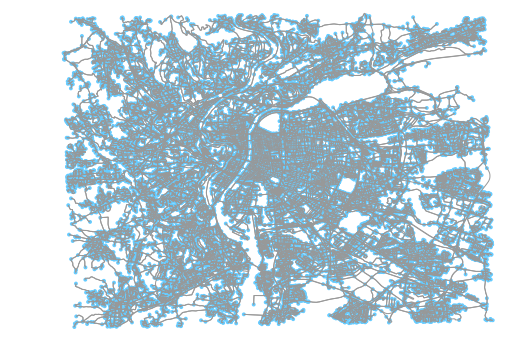

In [8]:
G = get_route_graph(city_ref)
f, ax = ox.plot_graph(G, fig_height=figsize[1], fig_width=figsize[0])
f.tight_layout()

# Urban sprawl indices
* Spatial indices are calculated in a regular grid

In [9]:
# Step in meters
step = 100
df_indices = get_indices_grid(df_osm_built, df_osm_building_parts, df_osm_pois, step=step)

# Land use mix

## Buildings
* Locations of residential and activity uses are retrieved
    * Red: Activity uses
    * Blue: Residential uses
    * Green: Mixed-uses

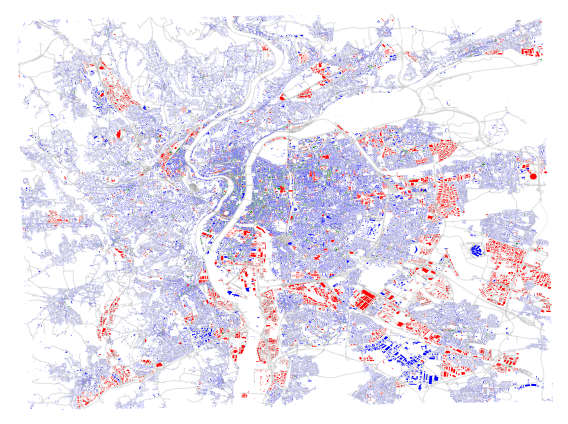

In [10]:
# Get buildings per classification
df_residential = df_osm_built[ df_osm_built.classification.isin(["residential"]) ]
df_activities = df_osm_built[ df_osm_built.classification.isin(["activity"]) ]
df_mixed = df_osm_built[ df_osm_built.classification.isin(["mixed"]) ]

# Plot
f, ax = ox.plot_graph(G, fig_height=figsize[1], fig_width=figsize[0], edge_alpha=0.15, node_alpha=0, show=False, close=False)
# Buildings
if (not df_residential.empty):
    df_residential.plot(figsize=figsize, color="blue", ax=ax)
if (not df_activities.empty):
    df_activities.plot(figsize=figsize, color="red", ax=ax)
if (not df_mixed.empty):
    df_mixed.plot(figsize=figsize, color="green", ax=ax)
ax.get_xaxis().set_visible(False);ax.get_yaxis().set_visible(False)
f.tight_layout()

## Points of Interest (POIs)
* Generally correspond to activity uses
* https://wiki.openstreetmap.org/wiki/Points_of_interest

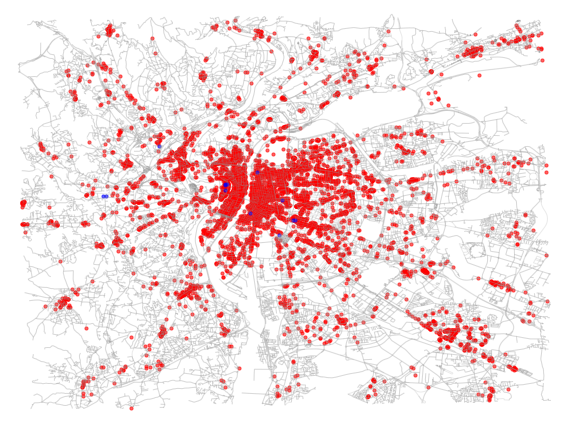

In [11]:
# Get POIs per classification
df_pois_activities = df_osm_pois[ df_osm_pois.classification.isin(["activity"]) ]
df_pois_residential = df_osm_pois[ df_osm_pois.classification.isin(["residential"]) ]
df_pois_mixed = df_osm_pois[ df_osm_pois.classification.isin(["mixed"]) ]

# Plot
f, ax = ox.plot_graph(G, fig_height=figsize[1], fig_width=figsize[0], edge_alpha=0.2, node_alpha=0, show=False, close=False)
# Points of Interest
if (not df_pois_activities.empty):
    df_pois_activities.plot(figsize=figsize, color="red", ax=ax, alpha=0.6, markersize=10)
if (not df_pois_residential.empty):
    df_pois_residential.plot(figsize=figsize, color="blue", ax=ax, alpha=0.6, markersize=10)
if (not df_pois_mixed.empty):
    df_pois_mixed.plot(figsize=figsize, color="green", ax=ax, alpha=0.6, markersize=10)
ax.get_xaxis().set_visible(False);ax.get_yaxis().set_visible(False)
f.tight_layout()

* Indices computation

In [12]:
landusemix_args = {'walkable_distance': 600, 'compute_activity_types_kde': True, 'weighted_kde': True, 
                   'pois_weight': 9, 'log_weighted': True}
%time compute_grid_landusemix(df_indices, df_osm_built, df_osm_pois, landusemix_args)

CPU times: user 23min 19s, sys: 17.1 s, total: 23min 37s
Wall time: 23min 37s


* Densities associated to these land usages are estimated

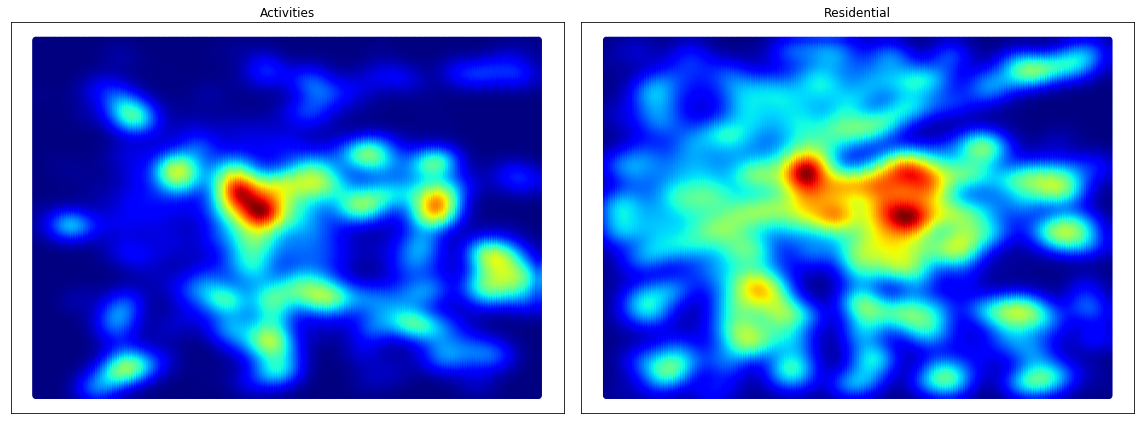

In [13]:
fig, axs = plt.subplots(1,2, figsize=(figsize[0] * 2, figsize[1]))
# Title
axs[0].set_title("Activities"); axs[1].set_title("Residential")
axs[0].get_xaxis().set_visible(False);axs[0].get_yaxis().set_visible(False)
axs[1].get_xaxis().set_visible(False);axs[1].get_yaxis().set_visible(False)
# Plots
df_indices.plot("activity_pdf", figsize=figsize, cmap='jet', ax=axs[0])
df_indices.plot("residential_pdf",figsize=figsize, cmap='jet', ax=axs[1])
fig.tight_layout()

* Activities land uses can be further classified

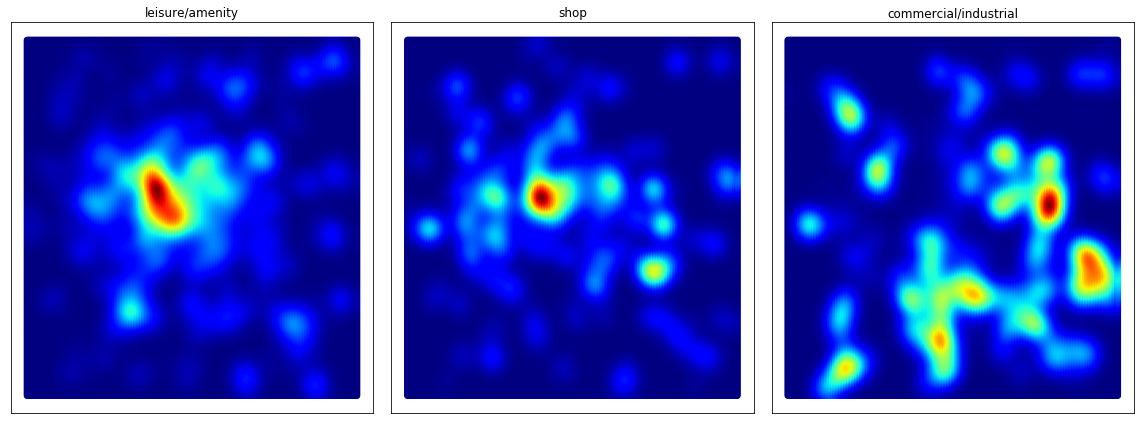

In [14]:
fig, axs = plt.subplots(1, len(activity_classification), figsize=(figsize[0] * 2, figsize[1]) )
for activity, ax_ in zip( activity_classification, axs ):
    if (activity+"_pdf" in df_indices.columns):
        ax_.set_title(activity); ax_.get_xaxis().set_visible(False);ax_.get_yaxis().set_visible(False)
        df_indices.plot(activity+"_pdf",figsize=figsize, cmap='jet', legend=False, ax=ax_)
fig.tight_layout()

* Land use mix indices
    * Land use mix (color): Degree of co-occurence of differing land usages within 'walkable' distances
    * Land use intensity (bubbles): Intensity of usage within a local context. The higher the intensity, the higher the desire of acquiring good uses mixture

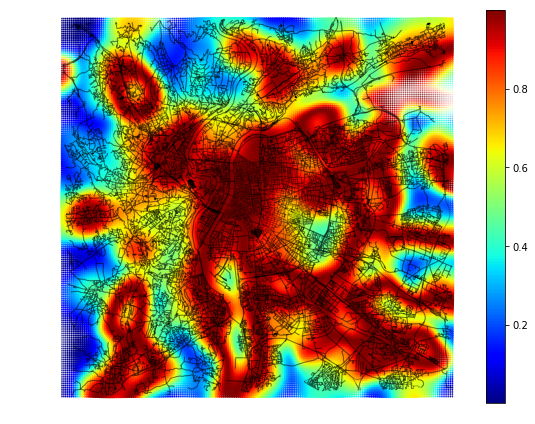

In [15]:
f, ax = ox.plot_graph(G, fig_height=figsize[1], fig_width=figsize[0], close=False, show=False, edge_color='black', edge_alpha=0.3, node_alpha=0.1)
df_indices.plot("landusemix", markersize=50*df_indices.landuse_intensity, figsize=figsize, cmap="jet", legend=True, ax=ax)
f.tight_layout()

# Accesssibility

### Street network is used
* Edges (roads) are cut, creating new nodes (road intersections) for its later processing

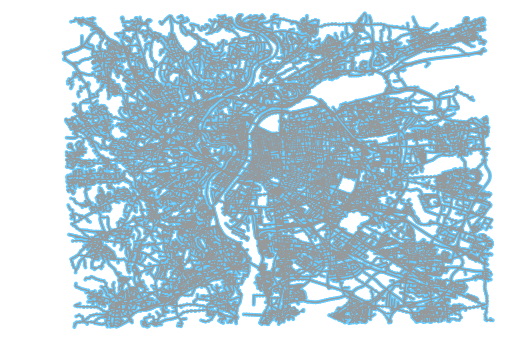

In [16]:
# Max edge length of 200 meters
max_edge_length = 200
divide_long_edges_graph(G, max_edge_length)
f, ax = ox.plot_graph(G, fig_height=figsize[1], fig_width=figsize[0])
f.tight_layout()

* Accessibility indices are calculated
    * Fixed distance: Denotes the cumulative opportunities access to activity land uses given a fixed maximum distance to travel
    * Fixed activities: Represents the distance needed to travel in order to reach a certain number of activity land uses

CPU times: user 22.5 s, sys: 1.79 s, total: 24.3 s
Wall time: 5h 32min 55s


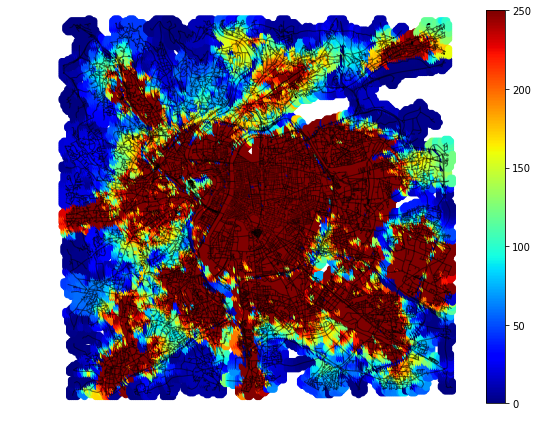

In [17]:
accessibility_args = {'fixed_distance': True, 'fixed_activities': False, 'max_edge_length': 200, 
                      'max_node_distance': 250, 'fixed_distance_max_travel_distance': 2000, 
                      'fixed_distance_max_num_activities': 250, 'fixed_activities_min_number': 20}
%time compute_grid_accessibility(df_indices, G, df_osm_built, df_osm_pois, accessibility_args)

### Plot
f, ax = ox.plot_graph(G, fig_height=figsize[1], fig_width=figsize[0], close=False, show=False, edge_color='black', edge_alpha=0.3, node_alpha=0.1)
df_indices.plot("accessibility", figsize=figsize, cmap='jet', legend=True, ax=ax)
f.tight_layout()

# Dispersion

* Dispersion indices are calculated:
    * Dispersion: "A landscape suffers from urban sprawl if it is permeated by urban development or solitary buildings [...]. The more area built over and the more dispersed the built-up area, [...] the higher the degree of urban sprawl" **(Jaeger and Schwick 2014)**
    * For each building, the distance (meters) to their nearest neighboring building is computed
    * The mean or median of these distances within a local radius are computed

CPU times: user 33min 33s, sys: 8.19 s, total: 33min 42s
Wall time: 33min 41s


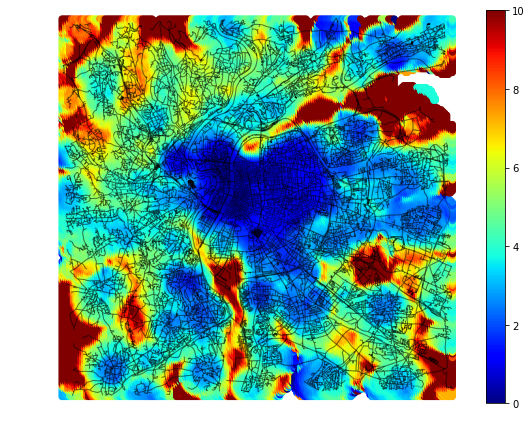

In [18]:
dispersion_args = {'radius_search': 750, 'use_median': False, 'K_nearest': 50}
%time compute_grid_dispersion(df_indices, df_osm_built, dispersion_args)

### Plot
f, ax = ox.plot_graph(G, fig_height=figsize[1], fig_width=figsize[0], close=False, show=False, edge_color='black', edge_alpha=0.3, node_alpha=0.1)
df_indices.plot('dispersion', figsize=figsize, cmap='jet', legend=True, vmax=10, ax=ax)
f.tight_layout()